参考：

[1] Kaggle Kernel: Introduction to CNN Keras - 0.997 (top 6%) 

(<https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6>)

[2] Kaggle Kernel: CNN Architectures : VGG, ResNet, Inception + TL 

(<https://www.kaggle.com/shivamb/cnn-architectures-vgg-resnet-inception-tl>)

# 1.0 Introduction

以下を記載する。

① データセットとして何を選んだか：MNIST(参考Kaggle Kernel[1]と同じ)

② 実装面で注意が必要だった点を該当箇所の近辺に

③ 日々の作業の進捗を、末尾に、変更履歴のような形で(他のメンバが参照する際に、前回参照時からの差分をすぐに理解できるように)：

20191203: 初版



## 1.1 ライブラリをインポート

In [0]:
# 各種ライブラリをインポートする。
%tensorflow_version 1.x
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
#%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.datasets import mnist

sns.set(style='white', context='notebook', palette='deep')

from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
import matplotlib.pyplot as plt 
from PIL import Image 
import seaborn as sns
import pandas as pd 
import numpy as np 
import os 

# 2.0 Data preparation



## 2.1 Load data

In [2]:
# Google Driveをmountする。
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# データセットを読み込む。
# データセットは参考Kaggle Kernel[1]と同じもの。
train = pd.read_csv("/content/drive/My Drive/TopSE/ソフトウェア開発実践演習/Kaggle_Kernel_Input/train.csv")
test = pd.read_csv("/content/drive/My Drive/TopSE/ソフトウェア開発実践演習/Kaggle_Kernel_Input/test.csv")

In [0]:
# トレーニングデータは、labelおよび784(=28x28)次元の画像データであることを確認。
train.head(5)

In [0]:
# テストデータは、784(=28x28)次元の画像データのみ。
test.head(5)

In [0]:
# trainを、正解ラベルと画像データに分割。
# 正解ラベル部分をY_trainに格納。
Y_train = train["label"]

# 画像データ部分をX_trainに格納。
X_train = train.drop(labels = ["label"], axis = 1)

In [0]:
# Y_trainを確認。
Y_train

In [0]:
# X_trainを確認。
X_train

In [0]:
# 各正解ラベルの出現頻度を確認し、偏りが無いことを確認する。
Y_train.value_counts()

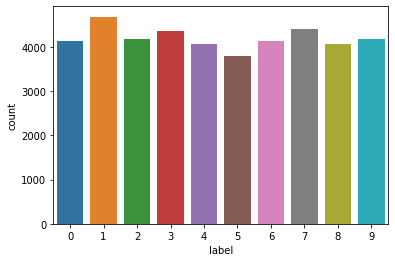

In [5]:
# 上記のラベルごとの出現頻度を可視化。
g = sns.countplot(Y_train)

##2.2 Check for null and missing values

In [6]:
# 欠損値がないことを確認。
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [7]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

## 2.3 Normalization

In [0]:
# 0~255の画像データを0~1に正規化する。
# 一般的に0~1または-1~1の値域に正規化する。
X_train = X_train / 255.0
test = test / 255.0

## 2.4 Reshape

In [0]:
# reshape(-1,28,28,1)の-1は、サイズ不変の意。
# Reshape image in 3 dimensions (height = 28px, width = 28px, cannel = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

## 2.5 Label encoding

In [12]:
# 0~9のラベルをone hot vectorsに変換。(ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
# なぜ必要か？[v2]
Y_train = to_categorical(Y_train, num_classes = 10)
print("Y_train: ", Y_train.shape)

Y_train:  (42000, 10)


## 2.6 Split training and valdiation set

In [0]:
# 学習用とテスト用のデータを分割。
# テスト用のデータの割合を10%に指定。

# Set the random seed
random_seed = 2
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

In [0]:
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("Y_train:", Y_train.shape)
print("Y_val:", Y_val.shape)

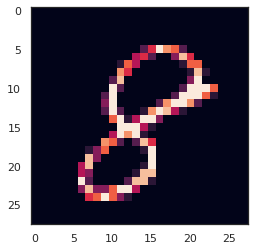

In [14]:
# Some examples
g = plt.imshow(X_train[0][:,:,0])

# 3.0 CNN

## 3.1 Define the model

In [0]:
# Inputサイズを724(28x28x1)->50176(=224x224x1)に変換する。
# Upsampling2Dの使い方分からず。層の最初には置けないのかも。

#from keras.layers import UpSampling2D
#tmp_x = X_train
#keras.layers.UpSampling2D(size=(2, 2), data_format=None)
#model.add(UpSampling2D(size=(2, 2)))

In [15]:
#del model

NameError: ignored

In [0]:
# VGG16のモデルを定義する。

model = Sequential()

input_size = (28,28,1)

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation ='relu', input_shape = input_size))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
#model.add(Dropout(0.25))

model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
#model.add(Dropout(0.25))

model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
#model.add(Dropout(0.25))

model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
#model.add(Dropout(0.25))

#model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = 'Same', activation ='relu'))
#model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = 'Same', activation ='relu'))
#model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = 'Same', activation ='relu'))
#model.add(MaxPool2D(pool_size=(2,2))) <- このpooling層でエラーが発生。サイズが小さくなりすぎか。
#model.summary()

model.add(Flatten())
model.add(Dense(4096, activation = "relu"))
#model.add(Dropout(0.5))
model.add(Dense(4096, activation = "relu"))
model.add(Dense(10, activation = "softmax"))

In [18]:
# CNNモデルの全体像を確認。
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 7, 7, 256)        

## 3.2 Set the optimizer and annealer

In [0]:
# RMSPropの引数はデフォルトでの使用を推奨されているが、epsilonがデフォルトではない模様。(デフォルト=None)
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [20]:
# 誤差関数はクロスエントロピー。評価関数は学習時には無関係。
# Compile the model
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics=["accuracy"])

In [0]:
# 3エポックの間、誤差関数が小さくならなくなったら、学習率を半分に下げる。
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [0]:
epochs = 30
batch_size = 86

## 3.3 Data augmentation

In [0]:
# Without data augmentation i obtained an accuracy of 0.98114
#history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
#          validation_data = (X_val, Y_val), verbose = 2)

In [0]:
# 回転および平行移動でaugumentationを実施。
# degrees, 0 to 180 -> -10 to 10 では？
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [24]:
# ミニバッチごとに前処理を行う場合はfitの代わりにfit.generatorを使用する。
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch = X_train.shape[0] // batch_size,
                              callbacks = [learning_rate_reduction])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/30





 - 25s - loss: 8.2744 - acc: 0.1106 - val_loss: 14.2568 - val_acc: 0.1155
Epoch 2/30
 - 16s - loss: 14.3279 - acc: 0.1111 - val_loss: 14.2568 - val_acc: 0.1155
Epoch 3/30
 - 16s - loss: 14.3279 - acc: 0.1111 - val_loss: 14.2568 - val_acc: 0.1155
Epoch 4/30
 - 16s - loss: 14.3321 - acc: 0.1108 - val_loss: 14.2568 - val_acc: 0.1155

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/30
 - 16s - loss: 14.3211 - acc: 0.1115 - val_loss: 14.2568 - val_acc: 0.1155
Epoch 6/30
 - 16s - loss: 14.3312 - acc: 0.1109 - val_loss: 14.2568 - val_acc: 0.1155
Epoch 7/30
 - 17s - loss: 14.3268 - acc: 0.1111 - val_loss: 14.2568 - val_acc: 0.1155

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 8/30
 - 16s - loss: 14.3266 - acc: 0.1111 - val_loss: 14.2568 - val_acc: 0.1155
Epoch 9/30
 - 16s - loss: 14.3238 - acc: 0.1113 -

## [Additional] 3.4 Export Trained Model

In [0]:
# 学習済みのモデルをGoogle Driveにエクスポートしておく。
model.save('/content/drive/My Drive/TopSE/ソフトウェア開発実践演習/Kaggle_Kernel_Input/TrainedModel.hd5')
!ls -lh '/content/drive/My Drive/TopSE/ソフトウェア開発実践演習/Kaggle_Kernel_Input/TrainedModel.hd5'

# 4. Evaluate the model

## 4.1 Training and validation curves

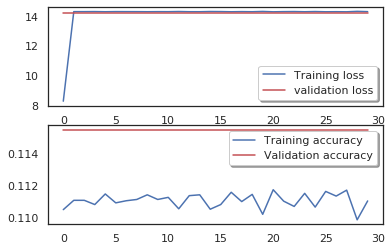

In [25]:
# epoch=2以上にしないとグラフは表示されない。
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## 4.2 Confusion matrix

In [0]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

In [0]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [0]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [0]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)